# Interpretability of the Image Quality Metrics (IQMs) of MRIQC

MRIQC is a powerful tool to assess the quality of MR images in a research study. In addition to a visual report, a number of image quality metrics (IQMs) is generated. However, there is a large number of these metrics and it is not immediately obvious which IQM a researcher should pay most attention to when deciding over the quality of a given image.

In this notebook, we will explore these issues in the MR-ART dataset, to provide researchers guidance in interpreting the IQMs from MRIQC.

In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from plotly.subplots import make_subplots

First, let's import the data. The [Movement-Related Artifacts (MR-ART)](https://openneuro.org/datasets/ds004173) dataset contains the T1-weighted images of 148 healthy subjects (Nárai et al. 2022). Each subject has been acquired under three motion conditions:

1. no head movement
2. little head movement
3. much head movement

The motion was artifically induced by giving the subjects cues when to node their head.

The images were given to two expert raters, who rated the images in their quality, with ratings

1. good quality
2. medium quality
3. bad quality.

What we are interested in here are the IQMs and the ratings scores.

In [6]:
# set path to the data, adjust to where you saved yours
path_data = os.path.abspath("../data/")
# import IQMs
iqms = pd.read_csv(os.path.join(path_data, "IQMs.tsv"), index_col="bids_name", sep="\t")
# import rating scores
scores = pd.read_csv(os.path.join(path_data, "scores.tsv"), index_col="bids_name", sep="\t")
# make sure they are in the same order
iqms.sort_index(inplace=True)
scores.sort_index(inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/data/code/data/group_T1w.tsv'

In [ ]:
def add_condition_column(scores):
    """Adds a column with the different movement conditions to the rating scores dataframe"""
    stand = scores.index.str.contains("standard")
    hm1 = scores.index.str.contains("motion1")
    hm2 = scores.index.str.contains("motion2")
    conditions = [
        (stand == True),
        (hm1 == True),
        (hm2 == True)]
    choices = [1, 2, 3]
    scores['condition'] = np.select(conditions, choices)
    return scores
scores = add_condition_column(scores)

## Rating scores and image conditions

We can explore how well the raters align in their scores with the motion condition. Does their rating reflect how much people moved in the scanner? Let's cross-tabulate them:

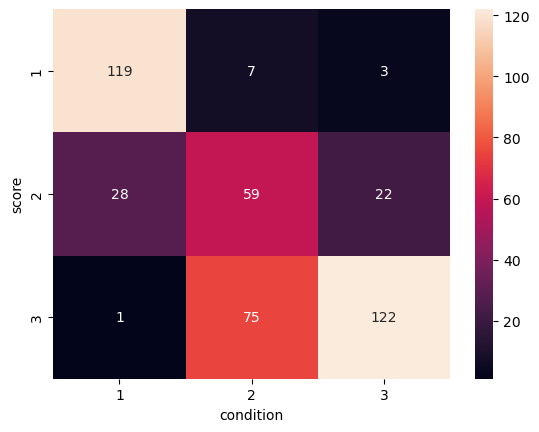

In [ ]:
sns.heatmap(pd.crosstab(scores["score"], scores["condition"]), annot=True, fmt=".0f")
plt.show()

We can see that generally there is good correspondance, with most values being on the main diagonal. Most confusion is for score 2, where there are also a lot of images from the no-motion as well as the much motion conditions.

Some images are however completely misclassified. We can visualize this also in a different way to be able to identify the images that were rated much better or much worse than the condition they were in.

In [ ]:
px.strip(scores, x="condition", y="score", color=scores.index)

The graphing library `plotly` allows to color the points according to the name of the image, such that we can identify the outliers by hovering over them. We can see that image `sub-613957_acq-standard_T1W` got a bad rating, even though this was the image from the no-motion condition. 

For the three images `sub-253493_acq-headmotion2_T1w`, `sub-257563_acq-headmotion2_T1w`, and `sub-567742_acq-headmotion2_T1w` we have the opposite case: these images got the best rating, even though the subjects were supposed to move their heads a lot during the acquisition of these images.

Try and look at the HTML reports of these images: can you guess what was likely going on in each of these cases?

## Visualizing the IQMs

Next, let's look at the IQMs. There are many different variables here:

In [ ]:
iqms.columns

Index(['cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z',
       'icvs_csf', 'icvs_gm', 'icvs_wm', 'inu_med', 'inu_range', 'qi_1',
       'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm', 'size_x', 'size_y', 'size_z',
       'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm',
       'snrd_total', 'snrd_wm', 'spacing_x', 'spacing_y', 'spacing_z',
       'summary_bg_k', 'summary_bg_mad', 'summary_bg_mean',
       'summary_bg_median', 'summary_bg_n', 'summary_bg_p05', 'summary_bg_p95',
       'summary_bg_stdv', 'summary_csf_k', 'summary_csf_mad',
       'summary_csf_mean', 'summary_csf_median', 'summary_csf_n',
       'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv',
       'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean',
       'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95',
       'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean',
       'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm

Some of them we can get rid of right away, as they are not really image quality metrics, but measurement parameters.

In [ ]:
iqms_use = iqms.drop(["size_x", "size_y", "size_z", "spacing_x", "spacing_y", "spacing_z"], axis=1)

We should also normalize the data, as the units of the IQMs vary wildly. This is required by some methods like PCA down the line, but it also makes sense computationally to have all values in the same order of magnitude.

In [ ]:
scaler = StandardScaler()
iqms_scaled = scaler.fit_transform(iqms_use)
iqms_scaled = pd.DataFrame(iqms_scaled, columns=iqms_use.columns, index=iqms_use.index)

Rule number one of data analysis: always visualize your data! We can plot the pairwise scatterplots to get an idea of the relationships between the IQMs. There are quite a few IQMs, so plottings this might take a few minutes, depending on your hardware.

In [ ]:
metrics_sets = {f"set{i+1}": list(iqms_scaled.columns[i*10:i*10+9]) for i in range(6)}
metrics_sets["set8"] = list(iqms_scaled.columns[60:])

In [ ]:
# for metrics_set in metrics_sets.values():
#     sns.pairplot(iqms_scaled[metrics_set])

Interesting! There are quite a few non-linear relationships between the IQMs, which we should keep in mind should linear dimension reduction techniques fail.
Next, let's do some dimensionality reduction.

## Dimensionality Reduction

### PCA

The simplest dimension reduction technique is principal component analysis (PCA), which projects the data onto a new set of axis defined by the eigenvectors of the data matrix. As the data are already rescaled, we can directly apply it.

In [ ]:
# run PCA
pca = PCA()
iqms_pca = pca.fit_transform(iqms_scaled)
col_names_pca = [f"component{i+1}" for i in range(62)]
iqms_pca = pd.DataFrame(iqms_pca, columns=col_names_pca)
# plot PCA
fig = px.scatter(iqms_pca, x="component1", y="component2", color=scores["condition"])
fig.show()

In [ ]:
fig = px.scatter(iqms_pca, x="component1", y="component2", color=scores["score"])
fig.show()

We can see that the first PCA component already separates both the ratings and the conditions quite well.

Here it makes sense to have a look at the loadings to get a sense of which variables contribute most to each component.

In [ ]:
loadings = pd.DataFrame(pca.components_[:2].T, index=iqms_scaled.columns)
px.imshow(loadings, color_continuous_midpoint=0, color_continuous_scale=px.colors.diverging.RdBu_r,
width=500, height=1300)#, center=0)

As we can see do the two components capture different information. We already know from the scatterplot that the first component is the one able to separate the conditions/ratings. When looking at the loadings of the first component, we get an idea which of the IQMs influence this component the most. [Here](https://mriqc.readthedocs.io/en/latest/iqms/t1w.html) is an overview of the different measures, that also tells us if higher or lower values indicate a better quality image. E.g., for CJV, lower is better, while for CNR, higher is better. This means that component 1 is related to the "badness" of the image, as the polarity of the loadings of CJV and CNR is opposite to the interpretation of their value.

### t-SNE

t-distributed Stochastic Neighbor Embedding (t-SNE) is another dimension reduction technique. Unlike PCA, it also captures non-linear relationships. It is often used for visualization purposes. Let's run t-SNE to get another visualization of the data in latent space:

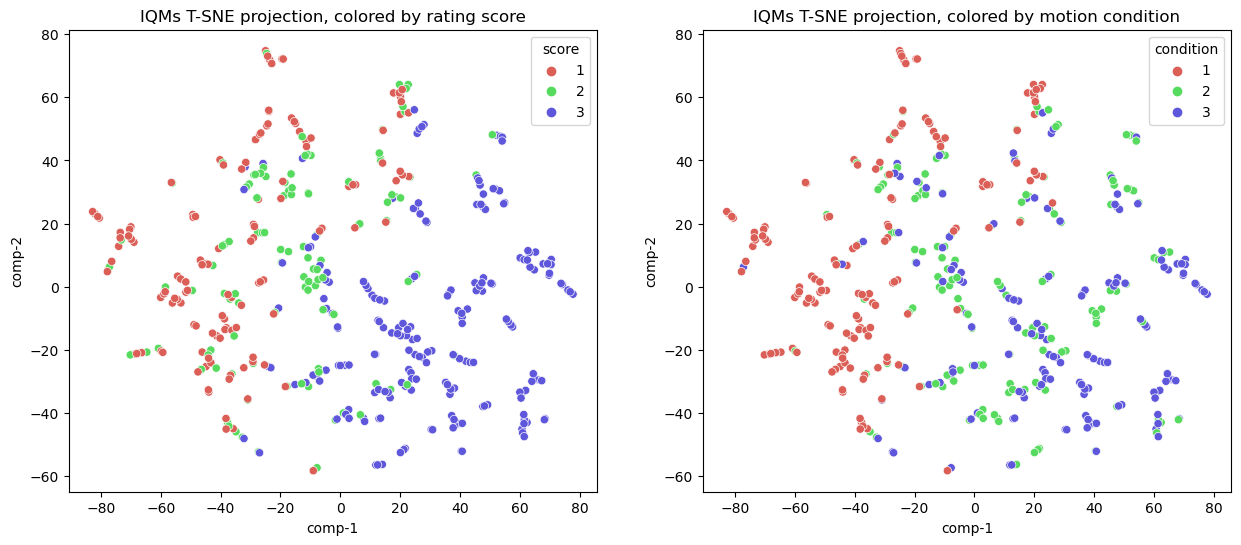

In [ ]:
# run TSNE
iqms_embedded = TSNE(n_components=2, learning_rate='auto', init='random' , perplexity=3, random_state=42).fit_transform(iqms_scaled)
# plot TSNE
iqms_embedded = pd.DataFrame(iqms_embedded, columns=["component1", "component2"])
df = pd.DataFrame()
df["score"] = scores["score"].copy()
df["condition"] = scores["condition"].copy()

df["comp-1"] = iqms_embedded["component1"].values
df["comp-2"] = iqms_embedded["component2"].values


fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x="comp-1", y="comp-2", hue="score",
                palette=sns.color_palette("hls", 3),
                data=df, ax=axs[0]).set(title="IQMs T-SNE projection, colored by rating score")
sns.scatterplot(x="comp-1", y="comp-2", hue="condition",
                palette=sns.color_palette("hls", 3),
                data=df, ax=axs[1]).set(title="IQMs T-SNE projection, colored by motion condition")
plt.show()

While different from the PCA components, the separation does not seem to improve. If anything, it is worse, as now both components are needed to separate images with rating score 1 from those with 2 or 3, instead of just one component when using PCA. The same is true when looking at the movement condition.

## Classification and Feature Importance

While dimension reduction in general and PCA in particular can give us an idea of which IQMs are useful in telling good from bad quality images, a more direct approach is to use the IQMs as features in a classification task.

To make things easier, we will binarize our target: condition/score 1 will be 0, conditions/scores 2 and 3 will be 1.

In [ ]:
scores["score_bin"] = np.where(scores["score"] == 1, 0, 1)
scores["condition_bin"] = np.where(scores["condition"] == 1, 0, 1)

### Classification using Support vector machine (SVM)

**Helper function**: A function for running multiple experiments using SVMs with the given kernel, to help find the best (kernel, C, gamma) combination. The values of C and gamma are varied following a geometric series.

The value of C controls the margin of the hyperplace, and as such, how "permeable" the hyperplane is. A low C means a wider margin around the hyperplane.

Gamma is important for the RBF kernel only (it doesn't impact the performance of the linear kernel)

In [ ]:
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def run_experiments(vectors, scores, svm_kernel):
  Cs = [2**c for c in range(-5, 11)]
  gammas = [2**g for g in range(-10, 3)]

  acc = []
  f1 = []

  N = len(vectors)
  N_train = int(0.9 * N)

  train_x = vectors[0:N_train]
  train_y = scores[0:N_train]

  test_x = vectors[N_train:]
  test_y = scores[N_train:]

  for C in Cs:
    for gamma in gammas:
      classif_n = svm.SVC(kernel=svm_kernel, C=C, gamma=gamma)
      classif_n.fit(train_x, train_y)
      pred_y = classif_n.predict(test_x)

      acc.append(accuracy_score(test_y, pred_y))
      f1.append(f1_score(test_y, pred_y, average='macro'))

  max_ind = f1.index(max(f1))

  return f1[max_ind], acc[max_ind], Cs[max_ind//len(gammas)], gammas[max_ind%len(gammas)] 

**Running SVM experiment**: finding the best combination of kernel, C and gamma

In [ ]:
for svm_kernel in ['linear', 'rbf', 'poly']:
  f1, acc, C, gamma = run_experiments(iqms_scaled, scores_bin, svm_kernel)
  print("Best performance for kernel {} for C = {} and gamma = {}:\n\t macro F1 = {}, acc = {}\n".format(svm_kernel, C, gamma, f1, acc))

**Helper functions**: For the SVM with a linear kernel, we can get feature coefficients that give us information about how good the feature is for classification. The higher the coefficient, the closer the hyperplane is to be orthogonal.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## we can only do this analysis for linear kernels 
def coefficient_analysis(C, gamma, vectors, scores, features):
  kernel = 'linear'

  N = len(vectors)
  N_train = int(0.9 * N)

  train_x = vectors[0:N_train]
  train_y = scores[0:N_train]

  test_x = vectors[N_train:]
  test_y = scores[N_train:]

  classif = svm.SVC(kernel=kernel, C=C, gamma=gamma)
  classif.fit(train_x, train_y)

  plot_features(classif.coef_[0], features)


def plot_features(coefs, feats):
  coefs, feats = map(list, zip(*sorted(zip(coefs, feats), reverse=True)))  

  figure(figsize=(14,6))
  plt.bar(feats, coefs)
  feature_names = np.array(feats)
  plt.xticks(np.arange(1, 1 + len(feats)), feature_names, rotation=60, ha='right')
  plt.show()

**Coefficient analysis for the linear kernel**
 
Find the best performing combination of C and gamma, and plot the coefficient analysis.

In [ ]:
svm_kernel = 'linear'
f1, acc, C, gamma = run_experiments(iqms_scaled, scores_bin, svm_kernel)
print("Best performance for kernel {} for C = {} and gamma = {}: macro F1 = {}, acc = {}".format(svm_kernel, C, gamma, f1, acc))

coefficient_analysis(C, gamma, iqms_scaled, scores_bin, iqms_use)

### Classification using ElasticNet

### Conclusion

Both supervised classification methods give converging evidence that the multiple variants of the SNR are the most important features to classify motion strength based on the IQMs.

## References

Nárai, Ádám, Petra Hermann, Tibor Auer, Péter Kemenczky, János Szalma, István Homolya, Eszter Somogyi, Pál Vakli, Béla Weiss, and Zoltán Vidnyánszky. 2022. “Movement-Related Artefacts (MR-ART) Dataset of Matched Motion-Corrupted and Clean Structural MRI Brain Scans.” Scientific Data 9 (1): 630. https://doi.org/10.1038/s41597-022-01694-8.